#### Valeria Rebagliati 4852454
#### dataset 12: movimenti


# Introduzione

Vengono forniti due dataset, il primo position che rappresenta i muovimenti e le cordinate degli spostamenti nel tempo, il secondo feature, che associa al primo varie feature per ogni azione; le feature danno informazioni sulle azioni dividendosi in tre macro-gruppi che sono: displacement, frequency, dynamic.
Per ogni azione svolta da un certo individuo (in totale 16 persone) vengono raccolti 2 video. Per tracciare l'azione vengono presi dei riferimenti nel corpo che chiameremo giunti e sono: occhi, naso, orecchie, spalle, gomiti e polsi.


Nel notebook mi occuperò delle azioni di trasporto, analizzerò le relazioni tra di esse e le metterò a confronto con le azioni di  tocco che appartengono allo stesso gruppo di muovimenti.


# Environment
- pandas
- pyarrow or fastparquet

```shell
![pip][conda][pipenv] install pandas pyarrow numpy
```

In [1]:
import pandas as pd
import numpy as np
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import sklearn 


from sklearn import preprocessing
from sklearn.cluster import KMeans

import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn import decomposition


In [2]:
positions_3d = "positions_3d.csv"
features = "features.parquet.gz"

In [3]:
#remove me!

In [4]:
#versione di sklearn utilizzata
print(sklearn.__version__)
#%pip install -U scikit-learn

1.1.1


In [5]:
positions_df = pd.read_csv(positions_3d, header=[0, 1], index_col=[0, 1, 2, 3]).astype(np.float16)

### Esplorazione

In [6]:
positions_df.head()

joint                              lear                 lelbow           \
variable                              x       y       z      x        y   
individual action   sample frame                                          
0          drinking 0      0      514.5 -355.50  2058.0  626.0  134.000   
                           1      515.0 -357.50  2060.0  626.0  134.000   
                           2      515.0 -357.50  2060.0  626.0  134.000   
                           3      515.0 -357.50  2060.0  626.0  134.000   
                           4      515.5 -359.75  2062.0  628.5  134.125   

joint                                       leye                 lshoulder  \
variable                               z       x       y       z         x   
individual action   sample frame                                             
0          drinking 0      0      1706.0  467.50 -369.00  2064.0     568.0   
                           1      1706.0  467.75 -371.00  2066.0     565.5   
                           2      1706.0  466.00 -373.25  2066.0     565.5   
                           3      1706.0  466.00 -373.25  2066.0     565.5   
                           4      1707.0  466.00 -373.25  2066.0     565.5   

joint                             ...  relbow    reye                  \
variable                          ...       z       x       y       z   
individual action   sample frame  ...                                   
0          drinking 0      0      ...  1678.0  366.50 -374.75  2070.0   
                           1      ...  1682.0  366.75 -377.00  2072.0   
                           2      ...  1682.0  366.75 -377.00  2072.0   
                           3      ...  1682.0  367.00 -379.25  2074.0   
                           4      ...  1682.0  367.00 -379.25  2074.0   

joint                            rshoulder                     rwrist          \
variable                                 x        y       z         x       y   
individual action   sample frame                                                
0          drinking 0      0       128.750 -72.9375  1891.0  42.84375  200.75   
                           1       128.875 -74.8750  1892.0  41.43750  200.00   
                           2       128.875 -74.8750  1892.0  41.43750  200.00   
                           3       128.875 -74.8750  1892.0  41.43750  200.00   
                           4       128.875 -74.8750  1892.0  41.43750  200.00   

joint                                     
variable                               z  
individual action   sample frame          
0          drinking 0      0      1469.0  
                           1      1473.0  
                           2      1473.0  
                           3      1473.0  
                           4      1473.0  

[5 rows x 33 columns]

In [7]:
positions_df.shape

(59941, 33)

In [8]:
positions_df.dtypes

joint      variable
lear       x           float16
           y           float16
           z           float16
lelbow     x           float16
           y           float16
           z           float16
leye       x           float16
           y           float16
           z           float16
lshoulder  x           float16
           y           float16
           z           float16
lwrist     x           float16
           y           float16
           z           float16
nose       x           float16
           y           float16
           z           float16
rear       x           float16
           y           float16
           z           float16
relbow     x           float16
           y           float16
           z           float16
reye       x           float16
           y           float16
           z           float16
rshoulder  x           float16
           y           float16
           z           float16
rwrist     x           float16
           y       

In [9]:
for i in range(positions_df.index.nlevels):
    index = positions_df.index.get_level_values(i).unique()
    print(index.name, ":", index, "\n")

individual : Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='individual') 

action : Index(['drinking', 'eat_crisp', 'open_close_bottle', 'rubiks_cube', 'sanitise',
       'touch_bottle', 'touch_rubiks_cube', 'transport_bottle',
       'transport_pen', 'transport_rubiks_cube'],
      dtype='object', name='action') 

sample : Int64Index([0, 1, 2], dtype='int64', name='sample') 

frame : Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            459, 460, 461, 462, 463, 464, 465, 466, 467, 468],
           dtype='int64', name='frame', length=469) 



In [10]:
for i in range(positions_df.columns.nlevels):
    col = positions_df.columns.get_level_values(i).unique()
    print(col.name, ":", col, "\n")

joint : Index(['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear',
       'relbow', 'reye', 'rshoulder', 'rwrist'],
      dtype='object', name='joint') 

variable : Index(['x', 'y', 'z'], dtype='object', name='variable') 



### Visualizzazione
Per avere un punto di partenza nell'analisi dei dati parto con la visualizzazione dei movimenti, attingendo dal primo dataset fornito, posistion; in questo modo sarà possibile formulare delle ipotesi su cui costruire test successivi.

Per farlo ho costruito la funzione di seguito che, data un'azione, una lista di giunti e una persona restituirà il grafico del movimento dei giunti di quella persona mentre svolge quella determinata azione.
In questo modo potremmo visualizzare il muovimento nello spazio con la traiettoria dei vari giunti.

In [11]:
def plot_action(action, joints, pearson):
    
    fig = plt.figure()
 
    ax = plt.axes(projection ='3d')
    
    #rotazione di 180 rispetto a y e 180 rispetto a x
    ax.view_init(90,90)
    
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    for i in range(0, len(joints)):
        
        z = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "z"]]
        x = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "x"]]
        y = positions_df.loc[idx[ pearson, action, 0, :], idx[joints[i], "y"]]

        ax.plot3D(x, y, z)

    plt.show()
    


Prima di vedere i grafici, posso fare delle supposizioni su quello che vedrò:
* i movimenti di tutte le componenti del viso per qualsiasi azione, saranno uguali ma con shift diversi, come i movimenti delle spalle, perchè stanno sullo stesso asse
* i movimenti presi dai giunti delle braccia saranno meno "rigidi" e indipendenti rispetto a quelli sopra
* le varie azioni di trasporto avranno movimenti simili

Per completezza nella rappresentazione prenderò tutti i giunti per chiarire il movimento generale.

Parto con la visualizzazione di trasporto bottiglia e a seguire tocco bottiglia:

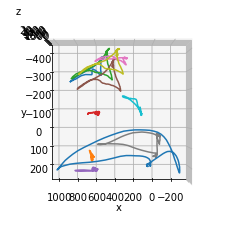

In [12]:
action = "transport_bottle"
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear', 'relbow', 'reye', 'rshoulder', 'rwrist']
plot_action(action,joints,0)

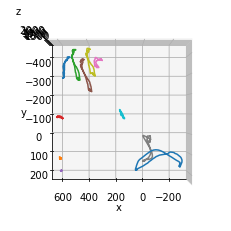

In [13]:
action = "touch_bottle"
plot_action(action, joints, 0)

Trasporto penna

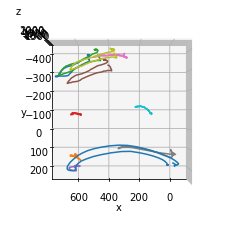

In [14]:
action = "transport_pen"
plot_action(action, joints, 0)

Poi trasporto del cubo di rubik per individuo 0 e 10, per vedere se persone diverse compiono allo stesso modo il medesimo movimento

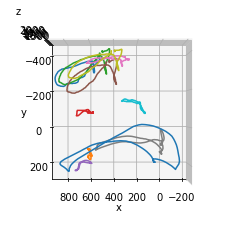

In [15]:
action = "transport_rubiks_cube"
plot_action(action,joints,0)

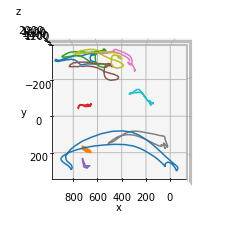

In [16]:
action = "transport_rubiks_cube"
plot_action(action, joints, 10)

Infine tocco del cubo di rubik della persona 10 per confrontarlo con il trasporto subito sopra

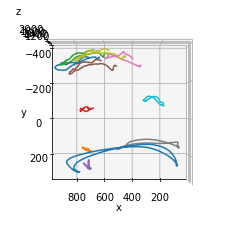

In [17]:
action = "touch_rubiks_cube"
plot_action(action, joints, 10)

Da una prima analisi visiva possiamo dire che come ci aspettavamo tutti i giunti del viso tracciano lo stesso disegno nello spazio. Stessa cosa per le spalle, anche se in generale, se la persona ruota la testa o le spalle verso destra o sinistra, la telecamera potrebbe non vedere più i giunti di riferimento e di conseguenza i dati potrebbero subire del rumore. 
I movimenti dei polsi non sono simmetrici.

Notiamo subito che qualsiasi sia l'oggetto trasportato la traiettoria del movimento è molto simile per tutti i traporti, anche se varia l'ampiezza.
I muovimenti del viso seguono quello del braccio destro che trasporta l'oggetto.

Infine notiamo che per l'individuo 0 il tocco e il trasporto della bottiglia non sono troppo simili, infatti la traiettoria del muovimento è simile ma nel tocco ha un'ampiezza minore; probabilmente questo dipende dalla posizione dell'oggetto sul tavolo rispetto all'individuo.
Per il tocco e il traporto del cubo di rubik per l'individuo 10 notiamo invece una somiglianza più forte, questo probabilmente è dovuto alla posizione dell'oggetto come detto precedentemente per la bottiglia.
Assumendo di prendere gli oggetti con la mano destra, se l'oggetto è alla propria destra il movimento sarà minimo, come forse è accaduto nel tocco della bottiglia, invece se è alla sinistra come forse è stato nel tocco del cubo di rubik il movimento totale è più simile al trasporto.

Le spalle fanno un muovimento minimo come ci si poteva aspettare e i gomiti "seguono" il muovimento del relativo polso, quello destro traccia un muovimento simile ma meno ampio e quello sinistro fa movimenti impercettibili come il relativo polso.

# Features

units: meters and seconds

In [18]:
features_df = pd.read_parquet(features).applymap(lambda x: x.astype(np.float16))

### Esplorazione

In [19]:
features_df.head(1)

type_feature                                                       displacement  \
data                                                                  positions   
feature                                                        max_displacement   
variable                                                                      x   
joint person action   sample                                                      
lear  0      drinking 0       [0.015, 0.0205, 0.0285, 0.036, 0.044, 0.054, 0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      y   
joint person action   sample                                                      
lear  0      drinking 0       [0.02174, 0.02824, 0.03275, 0.03925, 0.04575, ...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      z   
joint person action   sample                                                      
lear  0      drinking 0       [0.014, 0.017, 0.019, 0.022, 0.024, 0.025, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                              magnitude   
joint person action   sample                                                      
lear  0      drinking 0       [0.0299, 0.03882, 0.0474, 0.05762, 0.0679, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                      total_displacement   
variable                                                                      x   
joint person action   sample                                                      
lear  0      drinking 0       [0.015, 0.02, 0.028, 0.0355, 0.043, 0.053, 0.0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      y   
joint person action   sample                                                      
lear  0      drinking 0       [0.01525, 0.02374, 0.02824, 0.03476, 0.0435, 0...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                                      z   
joint person action   sample                                                      
lear  0      drinking 0       [-0.008, -0.013, -0.015, -0.018, -0.022, -0.02...   

type_feature                                                                     \
data                                                                              
feature                                                                           
variable                                                              magnitude   
joint person action   sample                                                      
lear  0      drinking 0       [0.02284, 0.03366, 0.0425, 0.05283, 0.065, 0.0...   

type_fea

In [20]:
features_df.shape

(3520, 158)

In [21]:
features_df.dtypes

type_feature  data       feature             variable 
displacement  positions  max_displacement    x            object
                                             y            object
                                             z            object
                                             magnitude    object
                         total_displacement  x            object
                                                           ...  
dynamic       jerk       skewness            magnitude    object
                         kurtosis            x            object
                                             y            object
                                             z            object
                                             magnitude    object
Length: 158, dtype: object

In [22]:
type(features_df.iloc[0, 0])

numpy.ndarray

In [23]:
features_df.iloc[0, 0].dtype

dtype('float16')

In [24]:
for i in range(features_df.index.nlevels):
    print(features_df.index.get_level_values(i).unique())

Index(['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear',
       'relbow', 'reye', 'rshoulder', 'rwrist'],
      dtype='object', name='joint')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='person')
Index(['drinking', 'eat_crisp', 'open_close_bottle', 'rubiks_cube', 'sanitise',
       'touch_bottle', 'touch_rubiks_cube', 'transport_bottle',
       'transport_pen', 'transport_rubiks_cube'],
      dtype='object', name='action')
Int64Index([0, 1, 2], dtype='int64', name='sample')


In [25]:
for i in range(features_df.columns.nlevels):
    print(features_df.columns.get_level_values(i).unique())

Index(['displacement', 'frequency', 'dynamic'], dtype='object', name='type_feature')
Index(['positions', 'velocities', 'acceleration', 'jerk'], dtype='object', name='data')
Index(['max_displacement', 'total_displacement', 'peak_power_density',
       'entropy_power_density', 'sum_power_density', 'maximum',
       'third_quartile', 'second_quartile', 'first_quartile', 'minimum', 'iqr',
       'ptp', 'mean', 'variance', 'standard_deviation', 'skewness',
       'kurtosis'],
      dtype='object', name='feature')
Index(['x', 'y', 'z', 'magnitude'], dtype='object', name='variable')


---

## Correlazione

Secondo le osservazioni fatte sopra provo a formulare le seguenti ipotesi che validerò o meno con il calcolo della correlazione:

1. Ci aspettiamo alta correlazione tra i vari giunti del viso per ogni azione (noi consideriamo solo quelle di trasporto, ma dovrebbe valere per tutte)
2. Dovrebbe esserci alta correlazione tra tutti gli individui che compiono la medesima azione
3. Ci aspettiamo alta correlazione tra i vari muovimenti di trasporto preso lo stesso individuo e lo stesso giunto; prenderemo in considerazione il polso destro che è quello che compie la maggior parte del lavoro nei muovimenti di trasporto
4. Ci aspettiamo una correlazione alta anche tra le azioni di trasporto e tocco del cubo di rubik
5. Verifichiamo la correlazione tra i muovimenti del polso destro e degli occhi nel muovimento di trasporto
6. Osservo la correlazione di tutte le feature data una persona e un'azione

1. Ipotesi 1: Verifichiamo che i giunti del viso si muovono allo stesso modo nel movimento di trasporto

<AxesSubplot:title={'center':'total displacement trasporto penna - occhio destro'}>

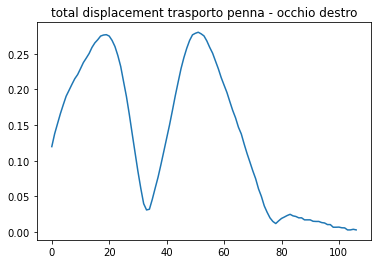

In [26]:
occhiodx=features_df.loc[
    idx["reye", 0, "transport_pen", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:180]

occhiodx.plot(title="total displacement trasporto penna - occhio destro")

<AxesSubplot:title={'center':'total displacement trasporto penna - occhio sinistra'}>

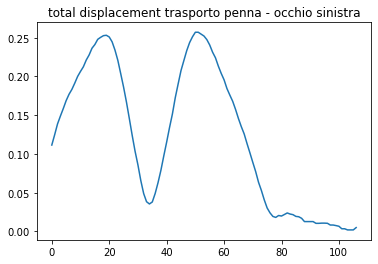

In [27]:
occhiosx=features_df.loc[
    idx["leye", 0, "transport_pen", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:180]

occhiosx.plot(title="total displacement trasporto penna - occhio sinistra")

<AxesSubplot:title={'center':'total displacement trasporto penna - naso'}>

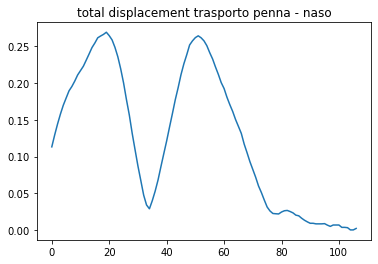

In [28]:
naso=features_df.loc[
    idx["nose", 0, "transport_pen", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:180]

naso.plot(title="total displacement trasporto penna - naso")

In [29]:
np.corrcoef(occhiodx.astype(float),occhiosx.astype(float))

array([[1.        , 0.99838958],
       [0.99838958, 1.        ]])

In [30]:
np.corrcoef(naso.astype(float),occhiodx.astype(float))

array([[1.        , 0.99913542],
       [0.99913542, 1.        ]])

In [31]:
np.corrcoef(naso.astype(float),occhiosx.astype(float))

array([[1.        , 0.99847977],
       [0.99847977, 1.        ]])

Notiamo sia guardando i grafici del total displacement di occhi e naso che sono identici, e facendo la correlazione a coppie tra gli elementi presi in considerazione risulta molto alta in quanto i valori sull'antidiagonale delle matrici sono molto vicini a 1. Quindi la prima ipotesi formulata è stata validata facendo la correlazione.

2. Ipotesi 2: Tutte le persone fanno lo stesso muovimento nel trasporto?

Correlazione del movimento del trasporto della bottiglia tra tutti gli individui:

[-0.11303063541727633, -0.21632497181050744, -0.30241585628156015, 0.35138643394346003, 0.3385912225398638, 0.9315457587185464, -0.6627069089095527, 0.7233367323214087, -0.6856897259138245, -0.8704810864629557, -0.2528847059247299, -0.24698415695386666, 0.8520240589430632, -0.1768874903269421, 0.4764743716879171]


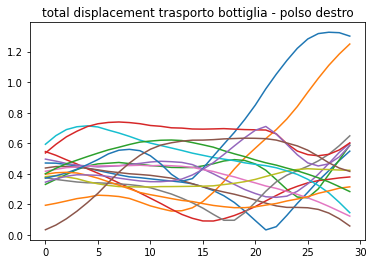

In [32]:
alldr = []

for i in range(0,16):
    alldr.append(features_df.loc[
        idx["rwrist", i, "transport_bottle", [1]],
        idx["displacement", "positions", "total_displacement", "magnitude"]
    ].explode().reset_index(drop=True)[:30])


for i in range(0, len(alldr)):
    alldr[i].plot(title="total displacement trasporto bottiglia - polso destro")
    
corr = []
for i in range(0, len(alldr)-1):
    corr.append(np.corrcoef(alldr[i].astype(float), alldr[i+1].astype(float))[0,1])

print(corr)

Ho calcolato la correlazione del movimento di un individuo con quello successivo, non ho stampato direttamente i valori dell'antidiagonale che risultava da ogni matrice; notiamo che per 2 individui il movimento è correlato perchè abbiamo valori molto vicino a 1, per la maggior parte non c'è correlazione, e per alcuni c'è una correlazione inversa.


3. Ipotesi 3: preso il polso destro dell'individuo 0 calcoliamo la correlazione nei muovimenti nel compiere le tre azioni di trasporto (cubo di rubik, bottiglia, penna)

<AxesSubplot:title={'center':'total displacement trasporto cubo di rubik - polso destro'}>

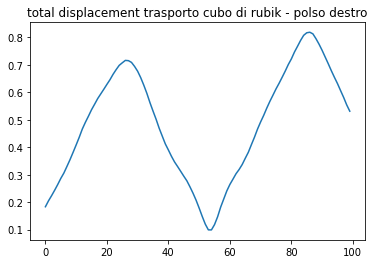

In [33]:
rtrc = features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtrc.plot(title="total displacement trasporto cubo di rubik - polso destro")

<AxesSubplot:title={'center':'total displacement trasporto bottiglia - polso destro'}>

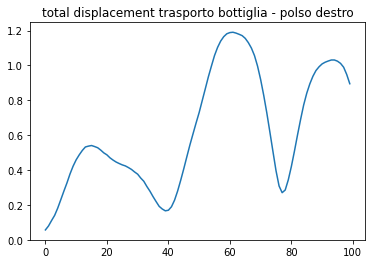

In [34]:
rtb = features_df.loc[
    idx["rwrist", 0, "transport_bottle", [0]],
        idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtb.plot(title="total displacement trasporto bottiglia - polso destro")

<AxesSubplot:title={'center':'total displacement trasporto penna - polso destro'}>

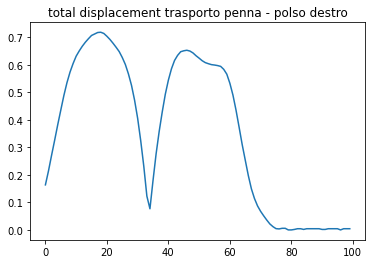

In [35]:
rtp = features_df.loc[
    idx["rwrist", 0, "transport_pen", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtp.plot(title="total displacement trasporto penna - polso destro")

In [36]:
np.corrcoef(rtrc.astype(float),rtb.astype(float))

array([[ 1.        , -0.06086439],
       [-0.06086439,  1.        ]])

In [37]:
np.corrcoef(rtrc.astype(float),rtp.astype(float))

array([[ 1.        , -0.49922837],
       [-0.49922837,  1.        ]])

In [38]:
np.corrcoef(rtb.astype(float),rtp.astype(float))

array([[ 1.        , -0.21477656],
       [-0.21477656,  1.        ]])

Contrariamente rispetto a quanto ci aspettavamo il muovimento dello stesso individuo mentre sposta oggetti diversi è molto scorrelato, guardando altre feature potrebbe cambiare qualcosa?

Osserviamo quindi il la velocità media del movimento:


<AxesSubplot:title={'center':'velocità media trasporto cubo di rubik - polso destro'}>

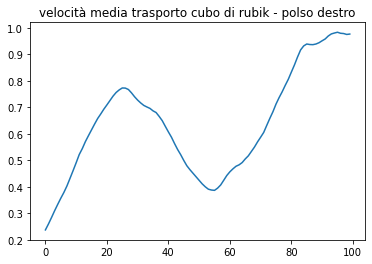

In [39]:
rtrc = features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtrc.plot(title="velocità media trasporto cubo di rubik - polso destro")

<AxesSubplot:title={'center':'velocità media trasporto bottiglia - polso destro'}>

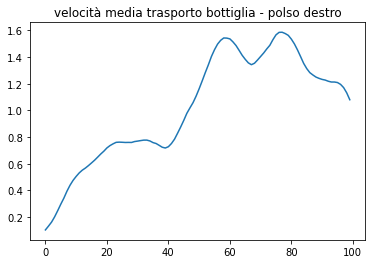

In [40]:
rtb = features_df.loc[
    idx["rwrist", 0, "transport_bottle", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtb.plot(title="velocità media trasporto bottiglia - polso destro")

<AxesSubplot:title={'center':'velocità media trasporto penna - polso destro'}>

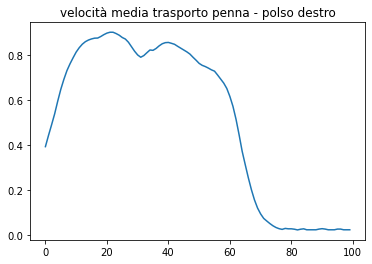

In [41]:
rtp = features_df.loc[
    idx["rwrist", 0, "transport_pen", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtp.plot(title="velocità media trasporto penna - polso destro")

In [42]:
np.corrcoef(rtrc.astype(float),rtb.astype(float))

array([[1.        , 0.30436968],
       [0.30436968, 1.        ]])

In [43]:
np.corrcoef(rtrc.astype(float),rtp.astype(float))

array([[ 1.        , -0.52260077],
       [-0.52260077,  1.        ]])

In [44]:
np.corrcoef(rtb.astype(float),rtp.astype(float))

array([[ 1.        , -0.60741374],
       [-0.60741374,  1.        ]])

Anche valutando la velocità media dello spostamento vediamo che i muovimenti non risultano correlati, forse perchè la forza messa nel prendere un oggetto piuttosto che un altro è diversa. Tra il muovimento di trasporto della penna e della bottiglia c'è una livie correlazione inversa.


Proviamo infine a controllare la correlazione considerando le feature di frequency:

<AxesSubplot:title={'center':'peak_power_density trasporto cubo di rubik - polso destro'}>

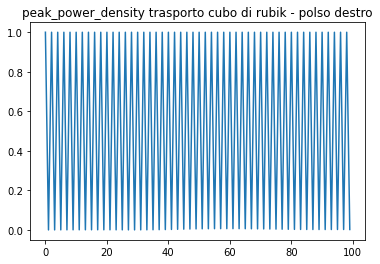

In [45]:
rtrc = features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0]],
    idx["frequency", "positions", "peak_power_density", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtrc.plot(title="peak_power_density trasporto cubo di rubik - polso destro")

<AxesSubplot:title={'center':'peak_power_density trasporto bottiglia - polso destro'}>

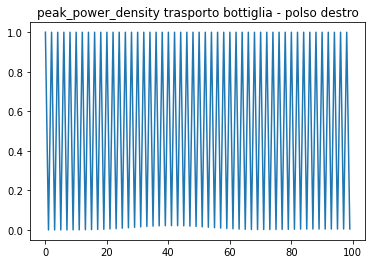

In [46]:
rtb = features_df.loc[
    idx["rwrist", 0, "transport_bottle", [0]],
    idx["frequency", "positions", "peak_power_density", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtb.plot(title="peak_power_density trasporto bottiglia - polso destro")

<AxesSubplot:title={'center':'peak_power_density trasporto penna - polso destro'}>

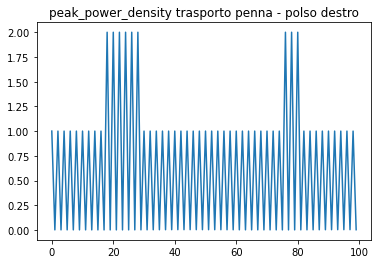

In [47]:
rtp = features_df.loc[
    idx["rwrist", 0, "transport_pen", [0]],
    idx["frequency", "positions", "peak_power_density", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtp.plot(title="peak_power_density trasporto penna - polso destro")

In [48]:
np.corrcoef(rtrc.astype(float),rtb.astype(float))

array([[1.        , 0.99994949],
       [0.99994949, 1.        ]])

In [49]:
np.corrcoef(rtrc.astype(float),rtp.astype(float))

array([[1.       , 0.9081366],
       [0.9081366, 1.       ]])

In [50]:
np.corrcoef(rtb.astype(float),rtp.astype(float))

array([[1.       , 0.9081018],
       [0.9081018, 1.       ]])

La correlazione in questo caso è altissima, sotto il punto di vista della frequenza le tre azioni sono fortemente correlate

Di seguito le correlazioni delle tre azioni rispetto all'accelerazione media

<AxesSubplot:title={'center':'accelerazione media trasporto cubo di rubik - polso destro'}>

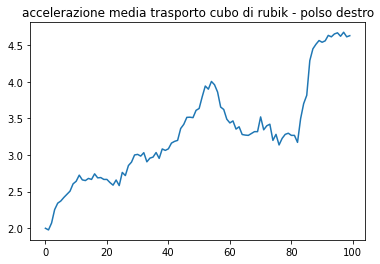

In [51]:
rtrc = features_df.loc[
    idx["rwrist", 0, "transport_rubiks_cube", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtrc.plot(title="accelerazione media trasporto cubo di rubik - polso destro")

<AxesSubplot:title={'center':'accelerazione media trasporto bottiglia - polso destro'}>

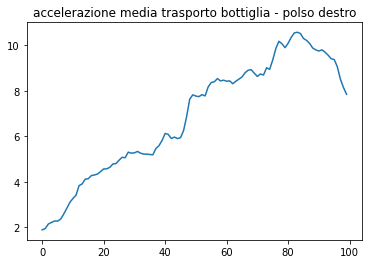

In [52]:
rtb = features_df.loc[
    idx["rwrist", 0, "transport_bottle", [0]],
        idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtb.plot(title="accelerazione media trasporto bottiglia - polso destro")

<AxesSubplot:title={'center':'accelerazione media trasporto penna - polso destro'}>

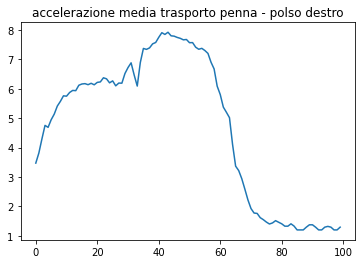

In [53]:
rtp = features_df.loc[
    idx["rwrist", 0, "transport_pen", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

rtp.plot(title="accelerazione media trasporto penna - polso destro")

In [54]:
np.corrcoef(rtrc.astype(float),rtb.astype(float))

array([[1.        , 0.78930221],
       [0.78930221, 1.        ]])

In [55]:
np.corrcoef(rtrc.astype(float),rtp.astype(float))

array([[ 1.        , -0.44319951],
       [-0.44319951,  1.        ]])

In [56]:
np.corrcoef(rtb.astype(float),rtp.astype(float))

array([[ 1.       , -0.5946043],
       [-0.5946043,  1.       ]])

C'è una correlazione alta tra accelerazione media del trasporto del cubo di rubik e del trasporto della bottiglia


4. Ipotesi 4: Correlazione tra trasporto e tocco del cubo di rubik

<AxesSubplot:title={'center':'peak_power_density tocco cubo di rubik - polso destro'}>

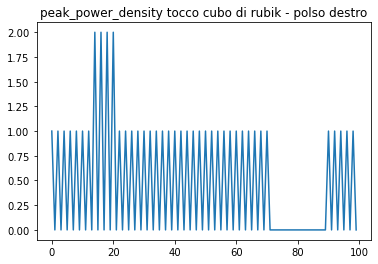

In [57]:
touch_rc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["frequency", "positions", "peak_power_density", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc.plot(title="peak_power_density tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'peak_power_density trasporto cubo di rubik - polso destro'}>

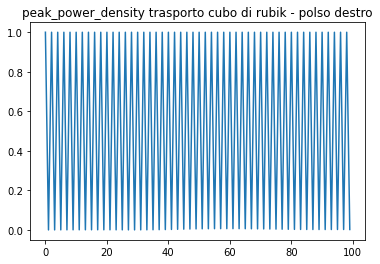

In [58]:
transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["frequency", "positions", "peak_power_density", "magnitude"]
].explode().reset_index(drop=True)[:100]

transport_rc.plot(title="peak_power_density trasporto cubo di rubik - polso destro")

In [59]:
np.corrcoef(touch_rc.astype(float),transport_rc.astype(float))

array([[1.        , 0.78632962],
       [0.78632962, 1.        ]])

<AxesSubplot:title={'center':'total displacement tocco cubo di rubik - polso destro'}>

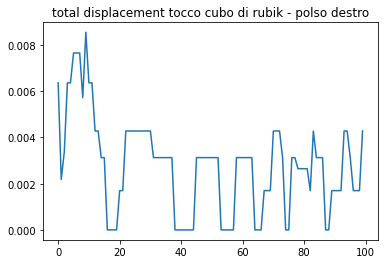

In [60]:
touch_rc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc.plot(title="total displacement tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'total displacement trasporto cubo di rubik - polso destro'}>

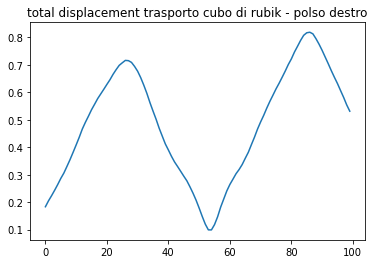

In [61]:
transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["displacement", "positions", "total_displacement", "magnitude"]
].explode().reset_index(drop=True)[:100]

transport_rc.plot(title="total displacement trasporto cubo di rubik - polso destro")

In [62]:
np.corrcoef(touch_rc.astype(float),transport_rc.astype(float))

array([[ 1.        , -0.01179343],
       [-0.01179343,  1.        ]])

<AxesSubplot:title={'center':'accelerazione media tocco cubo di rubik - polso destro'}>

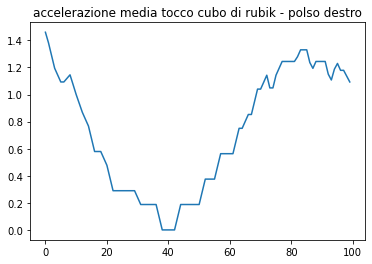

In [63]:
touch_rc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]
].explode().reset_index(drop=True)[:100]

touch_rc.plot(title="accelerazione media tocco cubo di rubik - polso destro")

<AxesSubplot:title={'center':'accelerazione media trasporto cubo di rubik - polso destro'}>

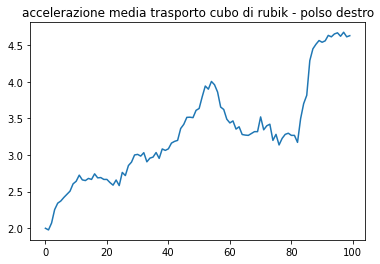

In [64]:
transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", [0]],
    idx["dynamic", "acceleration", "mean", "magnitude"]

].explode().reset_index(drop=True)[:100]

transport_rc.plot(title="accelerazione media trasporto cubo di rubik - polso destro")

In [65]:
np.corrcoef(touch_rc.astype(float),transport_rc.astype(float))

array([[1.        , 0.19946077],
       [0.19946077, 1.        ]])

Sotto il punto di vista della frequenza abbiamo che le azioni di tocco e trasporto del cubo di rubik sono molto correlate, mentre sotto il punto di vista dello spostamento e della dinamica no. 

5. Ipotesi 5: Verifichiamo la correlazione rispetto all'accelerazione o displacement nel trasporto di occhi e polso

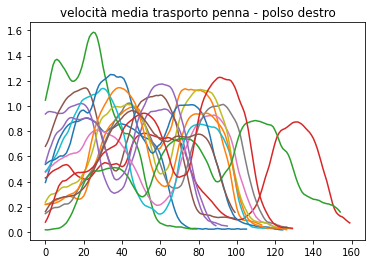

In [66]:
#polso destro

allrs = []

for i in range(0,16):
    allrs.append(features_df.loc[
        idx["rwrist", i, "transport_pen", [0]],
        idx["dynamic", "velocities", "mean", "magnitude"]
    ].explode().reset_index(drop=True)[:180])


for i in range(0, len(allrs)):
    allrs[i].plot(title="velocità media trasporto penna - polso destro")


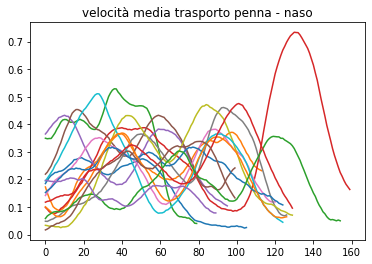

In [67]:
#naso

allls = []

for i in range(0,16):
    allls.append(features_df.loc[
    idx["nose", i, "transport_pen", [0]],
    idx["dynamic", "velocities", "mean", "magnitude"]
    ].explode().reset_index(drop=True)[:180])

for i in range(0, len(allls)):
    allls[i].plot(title="velocità media trasporto penna - naso")

In [68]:
#correlazione tra tutti gli individui tra polso destro e naso nel muovimento di trasporto
corr = []
for i in range(0, len(allrs)-1):
    corr.append(np.corrcoef(allrs[i].astype(float),allls[i].astype(float))[0,1])
print(corr)
#non stampo tutta la matrice perchè è illegibile, tengo solo i coefficenti significativi

[0.9633999689801318, 0.40265068495925577, 0.6630436866522713, 0.7421419999168507, 0.9334866556375271, 0.8960372973306678, 0.8620151691732757, 0.7503154321968989, 0.8529515035614661, 0.8560248687146829, 0.8263810018186591, 0.8155862294573373, 0.7188052194592298, 0.7315247815990357, 0.6928414491797037]


Come ci aspettavamo i muovimenti del viso, in questo caso rappresentati dal naso, e quelli del polso destro che effettua l'azione vera e propria, c'è un'altissima correlazione per quasi tutti gli individui, per alcuni questa correlazione scende, e solo per il secondo individuo non si nota quasi correlazione.

6. Ipotesi 6: prendo in considerazione il movimento del braccio destro nel trasporto della penna e calcolo la correlazione tra le varie feature della persona 0

In [69]:
transport_df = features_df.loc[idx["rwrist", 0, "transport_pen", 0]].reset_index(drop=True)
corr = []
for feature in transport_df:
    corr.append(feature[:100])
corrs = np.corrcoef(corr)

print(corrs)



[[1.         0.8871161  0.84535899 ... 0.29328203 0.65747638 0.64119909]
 [0.8871161  1.         0.93929837 ... 0.12836659 0.58217357 0.63664607]
 [0.84535899 0.93929837 1.         ... 0.30290373 0.67869331 0.73688009]
 ...
 [0.29328203 0.12836659 0.30290373 ... 1.         0.71213964 0.66768219]
 [0.65747638 0.58217357 0.67869331 ... 0.71213964 1.         0.97777131]
 [0.64119909 0.63664607 0.73688009 ... 0.66768219 0.97777131 1.        ]]


La matrice delle correlazioni ha dimensioni notevoli e non può essere visulizzata per intero, quindi la "navigo", per visualizzare in particolare la correlazione tra due feature. Ci aspettiamo che le feature legate a un macro-gruppo siano molto correlate tra loro, nel mio caso mi occuperò delle azioni di trasporto:

In [70]:
def corr_matrix(f1,f2,action):
    for i in range(16):
        person = features_df.loc[idx['rwrist', i, action, 0]]
        v = []

        index = (person.index)
        person = person.reset_index(drop=True)

        for a in person:
            v.append(a[:50])

        corr = np.corrcoef(v)
        print("Persona", i, ":", corr[np.argwhere(index == idx[f1]), np.argwhere(index == idx[f2])])

    return corr



Sfrutto la funzione appena creata per navigare la correlazione delle feature sulla stessa azione, parto mettendo a confronto il max e il total displacement, aspettandomi che ci sia molta correlazione, dato che appartengono alla stessa categoria di feature.

In [71]:
f1 ='displacement', 'positions', 'total_displacement', 'magnitude'
f2 ='displacement', 'positions', 'max_displacement', 'magnitude'
corr = corr_matrix(f1,f2, 'transport_pen')


Persona 0 : [[0.95262732]]
Persona 1 : [[0.99802477]]
Persona 2 : [[0.7483612]]
Persona 3 : [[0.94988572]]
Persona 4 : [[0.97456914]]
Persona 5 : [[0.99421071]]
Persona 6 : [[0.97951456]]
Persona 7 : [[0.99600001]]
Persona 8 : [[0.99542338]]
Persona 9 : [[0.98724193]]
Persona 10 : [[0.97770561]]
Persona 11 : [[0.99825089]]
Persona 12 : [[0.98796389]]
Persona 13 : [[0.97508586]]
Persona 14 : [[0.99403054]]
Persona 15 : [[0.99120909]]


/home/vale/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/vale/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/vale/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Si nota che preso il polso destro nell'azione di trasporto penna c'è una correlazione alta del max e total diplacement per ogni persona come ci aspettavamo.

Ora confrontiamo feature legate alla dinamica e ci aspettiamo un risultato simile rispetto a quello appena ottenuto, in particolare confrontiamo accelerazione e jerk che sono uno la derivata dell'altro quindi la correlazione deve essere molto forte:

In [72]:
f1 ='dynamic', 'acceleration', 'mean', 'magnitude'
f2 = 'dynamic', 'jerk', 'mean', 'magnitude'
corr = corr_matrix(f1,f2, 'transport_pen')

Persona 0 : [[0.91788493]]
Persona 1 : [[0.94016424]]
Persona 2 : [[0.80612486]]
Persona 3 : [[-0.15594425]]
Persona 4 : [[0.72139188]]
Persona 5 : [[0.84916629]]
Persona 6 : [[-0.14000818]]
Persona 7 : [[0.42637403]]
Persona 8 : [[0.96290034]]
Persona 9 : [[0.87833549]]
Persona 10 : [[0.81986395]]
Persona 11 : [[0.97923968]]
Persona 12 : [[0.87201592]]
Persona 13 : [[0.9722633]]
Persona 14 : [[0.93391575]]
Persona 15 : [[0.9854448]]


Si nota che le feature sono molto correlate ma non per tutti gli individui.

Ora valutiamo la correlazione delle stesse feature nelle altre due azioni di trasporto:

In [73]:
f1 ='displacement', 'positions', 'total_displacement', 'magnitude'
f2 ='displacement', 'positions', 'max_displacement', 'magnitude'
corr = corr_matrix(f1,f2, 'transport_bottle')

Persona 0 : [[0.90033165]]
Persona 1 : [[0.99499525]]
Persona 2 : [[0.85753725]]
Persona 3 : [[0.39666813]]
Persona 4 : [[0.88640882]]
Persona 5 : [[0.99740934]]
Persona 6 : [[0.90777169]]
Persona 7 : [[0.9974273]]
Persona 8 : [[0.98414126]]
Persona 9 : [[0.97677584]]
Persona 10 : [[0.96175939]]
Persona 11 : [[0.8298649]]
Persona 12 : [[0.96822456]]
Persona 13 : [[0.99931808]]
Persona 14 : [[0.98741018]]
Persona 15 : [[0.98174446]]


In [74]:
f1 ='dynamic', 'jerk', 'mean', 'magnitude'
f2 = 'dynamic', 'acceleration', 'mean', 'magnitude'
corr = corr_matrix(f1,f2, 'transport_bottle')

Persona 0 : [[0.97886519]]
Persona 1 : [[0.91199061]]
Persona 2 : [[0.88372408]]
Persona 3 : [[0.94383906]]
Persona 4 : [[0.97811248]]
Persona 5 : [[0.21732195]]
Persona 6 : [[0.86118309]]
Persona 7 : [[0.95775659]]
Persona 8 : [[0.97496063]]
Persona 9 : [[0.98263728]]
Persona 10 : [[0.94492801]]
Persona 11 : [[0.48282055]]
Persona 12 : [[0.77243348]]
Persona 13 : [[0.96960458]]
Persona 14 : [[0.97017606]]
Persona 15 : [[0.94504461]]


In [75]:
f1 ='displacement', 'positions', 'total_displacement', 'magnitude'
f2 ='displacement', 'positions', 'max_displacement', 'magnitude'
corr = corr_matrix(f1,f2, 'transport_rubiks_cube')

Persona 0 : [[0.98503835]]
Persona 1 : [[0.89943362]]
Persona 2 : [[0.96468497]]
Persona 3 : [[0.92079516]]
Persona 4 : [[0.99070513]]
Persona 5 : [[0.99405191]]
Persona 6 : [[0.99642129]]
Persona 7 : [[0.97508444]]
Persona 8 : [[0.98724687]]
Persona 9 : [[0.90918861]]
Persona 10 : [[0.98819292]]
Persona 11 : [[0.99973967]]
Persona 12 : [[0.92156605]]
Persona 13 : [[0.94361566]]
Persona 14 : [[0.95864182]]
Persona 15 : [[0.98803274]]


In [76]:
f1 ='dynamic', 'jerk', 'mean', 'magnitude'
f2 = 'dynamic', 'acceleration', 'mean', 'magnitude'
corr = corr_matrix(f1,f2, 'transport_rubiks_cube')

Persona 0 : [[0.95909704]]
Persona 1 : [[0.69463805]]
Persona 2 : [[0.92043481]]
Persona 3 : [[-0.10187552]]
Persona 4 : [[0.73268419]]
Persona 5 : [[0.82193712]]
Persona 6 : [[0.77211546]]
Persona 7 : [[0.84371341]]
Persona 8 : [[0.86843586]]
Persona 9 : [[0.97007733]]
Persona 10 : [[0.52977801]]
Persona 11 : [[0.9903544]]
Persona 12 : [[0.86033333]]
Persona 13 : [[0.94461425]]
Persona 14 : [[0.67165361]]
Persona 15 : [[0.92838817]]


I risultati sono molto simili a quelli che ottenuti per l'azione di trasporto della penna, quindi troviamo una correlazione alta tra feature della stessa categoria, per la stessa azione.

### T-Test

Come abbiamo visto dai grafici dei movimenti, quelli di trasporto e quelli di tocco del cubo di rubik sono molto simili, possiamo fare un test statistico per confermare l'ipotesi. Quindi avremo:

* H0 = l'azione di trasporto è simile a quella di tocco
* HA = l'azione di trasporto è diversa da quella di tocco

Usiamo il t-test per valutare le due ipotesi; in particolare valutiamo le due azioni rispetto alle feature legate al displacement.


Per fare il t-test è necessario prendere un campione rispetto alla popolazione totale, e devono valere le seguenti regole:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

Inoltre prenderemo come soglie:
* Livello di siginificatività : 0.05
* Livello di confidenza: 95%


Calcolo la popolazione totale

In [77]:
transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

transport_rc.shape

(3905,)

In [78]:
touch_rc = features_df.loc[
    idx["rwrist", :, "touch_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

touch_rc.shape

(3104,)

Quindi in questo caso abbiamo che:
1. n = 310 > 30
2. N è circa 3100

Seleziono il campione dal trasporto del cubo di rubik

In [79]:
a_transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:310]

a_transport_rc.shape

(310,)

Uso come popmean la popolazione totale del tocco, e come campione gli elementi selezionati dal trasporto

In [80]:
t_statistic, p_value = stats.ttest_1samp(a= a_transport_rc, popmean= touch_rc.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

t-statistic:  -0.2649089960600653
p-value:  0.7912561917969547


Dato che il p-value è maggiore del livello di significatività non posso rigettare l'ipotesi nulla, potremmo accettare l'ipotesi nulla se il p-value fosse >0.95.
Quindi c'è buona probabilità che le due azioni siano simili.

Ora verifichiamo quanto sono simili tra loro le azioni di trasporto dei vari oggetti, partiamo prendendo la popolazione totale per ogni azione di trasporto (quella di trasporto del cubo di rubik è sopra):

In [81]:
transport_b = features_df.loc[
    idx["rwrist", :, "transport_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

transport_b.shape

(4342,)

In [82]:
transport_p = features_df.loc[
    idx["rwrist", :, "transport_pen", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)

transport_p.shape

(3616,)

Quindi in questo caso abbiamo che:
1. n = 360 > 30
2. N è circa 3600

Di seguito prendiamo i campioni per ogni classe di azione:

In [83]:
a_transport_b = features_df.loc[
    idx["rwrist", :, "transport_bottle", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:360]

a_transport_b.shape

(360,)

In [84]:
a_transport_p = features_df.loc[
    idx["rwrist", :, "transport_pen", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:360]

a_transport_p.shape

(360,)

In [85]:
a_transport_rc = features_df.loc[
    idx["rwrist", :, "transport_rubiks_cube", :],
    idx['displacement', 'positions', 'max_displacement', 'magnitude']
].explode().reset_index(drop=True)[:360]

a_transport_rc.shape

(360,)

Ora formuliamo le varie ipotesi:

* 1.1. H0 = il trasporto del cubo di rubik è simile a quello del trasporto della bottiglia
* 1.2. HA = il trasporto del cubo di rubik e della bottiglia sono diverse
     

* 2.1. H0 = il trasporto del cubo di rubik è simile a quello del trasporto della penna
* 2.2. HA = il trasporto del cubo di rubik e della penna sono diversi


* 3.1. H0 = il trasporto della penna è simile a quello del trasporto della bottiglia
* 3.2. HA = il trasporto della penna e della bottiglia sono diversi

In [86]:
#bottiglia - cubo di rubik
print("1 - Confronto cubo di rubik e bottiglia")
t_statistic, p_value = stats.ttest_1samp(a= a_transport_b, popmean= transport_rc.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)
print("\n")

#cubo di rubik - penna
print("2 - Confronto cubo di rubik e penna")
t_statistic, p_value = stats.ttest_1samp(a= a_transport_rc, popmean= transport_p.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)
print("\n")

#penna - bottiglia
print("3 - Confronto bottiglia e penna")
t_statistic, p_value = stats.ttest_1samp(a= a_transport_p, popmean= transport_b.mean(), alternative='two-sided')
print("t-statistic: ",t_statistic)
print("p-value: ",p_value)

1 - Confronto cubo di rubik e bottiglia
t-statistic:  7.59019817384704
p-value:  2.7814420439376346e-13


2 - Confronto cubo di rubik e penna
t-statistic:  1.7174626443871441
p-value:  0.08675705089658785


3 - Confronto bottiglia e penna
t-statistic:  -9.260899570793743
p-value:  1.8912263402411815e-18


1. p-value < 0.05: **rigetto l'ipotesi nulla** in favore di quella alternativa
2. p-value > 0.05: **non posso rigettare l'ipotesi nulla**
3. p-value < 0.05: **rigetto l'ipotesi nulla** in favore di quella alternativa

Le uniche azioni simili sono quelle di trasporto di cubo di rubik e penna. Entrambe differiscono dal trasporto della bottiglia.

## Regressione Logistica - ML supervisionato

Possiamo usare un algoritmo di regressione logistica per classificare se un'azione è relativa al trasporto o al tocco del cubo di rubik

Passi da seguire:

1. Dividere dataset in training e test;
2. Istanziare un oggetto della classe LogisticRegression;
3. Fare fit su training set;
4. Usare la funzione score che fornisce l'accuratezza intesa come numero di volte in cui abbiamo predetto correttamente la classe rispetto al totale. 

In [87]:
# funzione che divide il data set in train e test

def my_train_test_slipt(X, joints, actions):
    n_features = X.columns.size
    n_joints = len(joints)
    n_people = 16
    n_actions = len(actions)
    n_samples = 50

    tr = np.asarray(X.loc[idx[joints, :, actions, 0]].reset_index(drop=True))
    te = np.asarray(X.loc[idx[joints, :, actions, 1]].reset_index(drop=True))
    y_train = np.asarray(X.loc[idx[joints, :, actions, 0]].reset_index()['action'])
    y_test = np.asarray(X.loc[idx[joints, :, actions, 1]].reset_index()['action'])

    y_train_fixed = np.zeros(shape=(n_samples * n_people * n_actions), dtype=(np.unicode_, 16))
    y_test_fixed = np.zeros(shape=(n_samples * n_people * n_actions), dtype=(np.unicode_, 16))
    X_train = np.zeros((n_people * n_actions, n_features * n_joints, n_samples), dtype=np.float64)
    X_test = np.zeros((n_people * n_actions, n_features * n_joints, n_samples), dtype=np.float64)

    for z in range(n_people * n_actions):
        for k in range(n_joints):
            for j in range(n_features):
                for i in range(n_samples):
                    X_train[z, j + (n_joints - 1), i] = tr[z + k * (n_joints - 1)][j][-i]
        for i in range(n_samples):
            y_train_fixed[z * n_samples + i] = y_train[z]

    for z in range(n_people * n_actions):
        for k in range(n_joints):
            for j in range(n_features):
                for i in range(n_samples):
                    X_test[z, j + (n_joints - 1), i] = te[z + k * (n_joints - 1)][j][-i]
        for i in range(n_samples):
            y_test_fixed[z * n_samples + i] = y_test[z]

    X_train = X_train.reshape(-1, n_features * n_joints)
    X_test = X_test.reshape(-1, n_features * n_joints)

    if np.where(y_train_fixed == ''):
        return X_train, X_test, y_train_fixed, y_test_fixed
    else : 
        print("Ci sono degli elementi nulli")

Calcolo la regressione logistica prendendo tutti i joints e tutte le feature della categoria displacement

In [88]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['transport_rubiks_cube', 'touch_rubiks_cube']

X = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [89]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)


0.513125

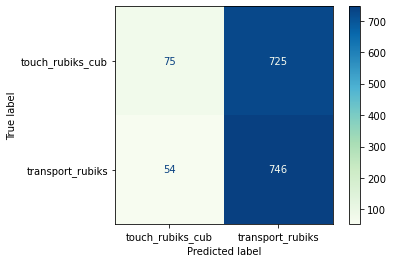

In [90]:

ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

Il risultato che abbiamo ottenuto dalla regressione logistica di trasporto e tocco del cubo di rubik non è soddisfacente, ma era prevedibile in quanto dal ttest fatto in precedenza risultava che le due azioni sono simili, quindi è normale che l'algoritmo non riesca a classificarle correttamente.

Se avessimo classificato le azioni in modo casuale avremmo ottenuto un regressor score simile che si aggira intorno allo 0.5 come nel nostro caso.

La confusion matrix ha sulla sua diagonale i valori classificati correttamente, quindi avremmo ottenuto un risultato ottimale se la diagonale fosse stata blu scuro (tanti valori sarebbero stati classificati correttamente); invece osservando la matrice emerge che molte delle tuple associate all'azione di trasport sono state classificate correttamente, ma la maggior parte delle tuple relative al tocco sono state classificate erroneamente.

---

Usiamo ora un algoritmo di regressione logistica per classificare un movimento in base alle tre azioni di trasporto: bottiglia, cubo di rubik e penna

In questo caso prendo solo il polso destro come joint e le feature di max_displacement sulla magnitude

In [91]:
joints = ['rwrist']
actions = ['transport_bottle', 'transport_rubiks_cube', 'transport_pen']

X = features_df.loc[idx[joints, :, actions, :],idx['displacement', 'positions', 'max_displacement', ['magnitude']]]

X_train,X_test,y_train_fixed,y_test_fixed = my_train_test_slipt(X, joints, actions)

In [92]:
regressor = LogisticRegression()

regressor.fit(X_train,y_train_fixed)
regressor.score(X_test,y_test_fixed)


0.37375

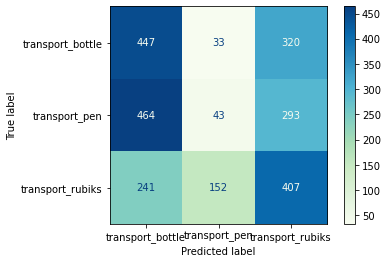

In [93]:
ConfusionMatrixDisplay.from_estimator(regressor, X_test, y_test_fixed, cmap='GnBu')

Anche in questo caso l'algoritmo ha difficoltà a classificare le varie azioni nelle tre categorie, in questo caso è meno giustificato in quanto dal ttest risultava che le azioni non sono simili dal punto di vista del displacement.

Dalla confusion matrix notiamo che vengono classficate meglio le tuple relative al trasporto della bottiglia a scendere quelle del trasporto del cubo di rubik e infine, solo pochissime tuple del trasporto della penna sono state classificate correttamente. 

Spicca una casella molto scura che incrocia trasporto penna e bottiglia; questo significa che è un falso negativo.

Nonostante lo score sia basso, le osservazioni fatte sulla confusion matrix sono coerenti con quanto visto nei ttest, infatti il trasporto bottiglia è quello che è stato classificato meglio, infatti differiva dalle altre due azioni.



## KMeans - ML non supervisionato 

Ora provo a clusterizzare il dataset con kmeans dividendolo nelle due azioni di trasporto e tocco del cubo di rubik; in questo modo posso osservare la differenza tra approccio supervisionato e non.

Considero tutti i joints e tutte le feature della categoria displacement come fatto per la regressione logistica

In [94]:
joints = ['lear', 'lelbow', 'leye', 'lshoulder', 'lwrist', 'nose', 'rear','relbow', 'reye', 'rshoulder', 'rwrist']

actions = ['transport_rubiks_cube', 'touch_rubiks_cube']

X1 = features_df.loc[idx[joints, :, actions, :],idx[['displacement']]]

n_features = X1.columns.size
n_joints = len(joints)
n_people = 16
n_actions = len(actions)
n_samples = 50


l = np.asarray(X1.loc[idx[joints, :, actions]].reset_index(drop=True))

X1 = np.zeros((n_people * n_actions * n_joints, n_features, n_samples), dtype=np.float64)

for z in range(len(X1)):
    for j in range(len(l[z])):
        for i in range(n_samples):
            X1[z, j, i] = l[z][j][i]
            
         
X1 = X1.reshape(-1, n_features)

scaler = preprocessing.StandardScaler().fit(X1)

X1 = scaler.transform(X1)



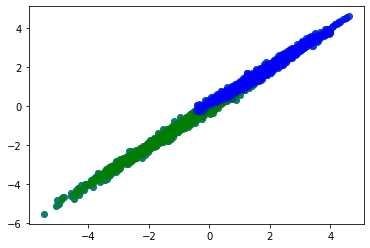

In [95]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X1)
y = kmeans.labels_
plt.scatter(X1[:,0],X1[:,1])
color = ['g','b']

for i in range(0,2):
    plt.scatter(X1[np.where(y==i),0],X1[np.where(y==i),1],color=color[i],alpha=0.3)


Per visualizzare meglio quanto ottenuto uso PCA

In [96]:
pca = decomposition.PCA(n_components=2)

In [97]:
X_pca = pca.fit_transform(X1)
print(X_pca.shape)


(17600, 2)


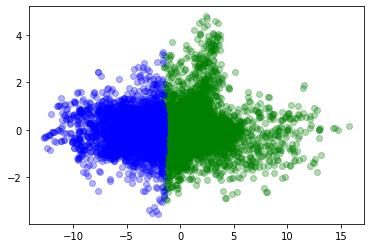

In [98]:
for i in range(0,2):
    plt.scatter(X_pca[np.where(y==i),0],X_pca[np.where(y==i),1],color=color[i],alpha=0.3)

Per capire la correttezza misuriamo l'indice di silhouette

In [99]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette(x):
    silhouette_avg = []
    for i in range(2, 16):
        kmeans = KMeans(n_clusters = i, max_iter = 20, random_state = 0)
        cluster_labels = kmeans.fit_predict(x)
        silhouette_avg.append(silhouette_score(x, cluster_labels))
    
    plt.plot(range(2, 16), silhouette_avg,'-o')
    plt.title('The silhouette method')
    plt.xlabel('Number of clusters')
    plt.ylabel('silhouette coefficient') #within cluster sum of squares
    plt.show()

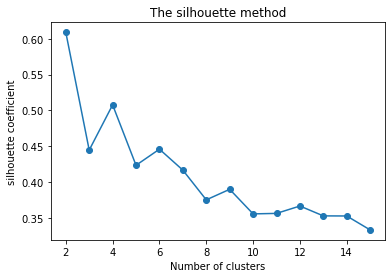

In [100]:
silhouette(X1)

Dal grafico risulta che il miglior indice di silhouette ottenibile è dividendo in due cluster.

---
Ora provo a clusterizzare il dataset in base alle persone nel compiere l'azione di trasporto cubo di rubik, quindi usando 16 cluster.
Considero il polso destro e il naso per avere un riferimento del viso come joints e come feature uso il max displacement di x, y e z


In [101]:
joints = ['rwrist', 'nose']
actions = ['transport_rubiks_cube']

X2 = features_df.loc[idx[joints, :, actions, :], idx['displacement', 'positions', 'max_displacement', ['x', 'y', 'z']]]

n_features = X2.columns.size
n_joints = len(joints)
n_people = 16
n_actions = len(actions)
n_samples = 50

l2 = np.asarray(X2.loc[idx[joints, :, actions]].reset_index(drop=True))

X2 = np.zeros((n_people * n_actions * n_joints, n_features, n_samples), dtype=np.float64)

for z in range(len(X2)):
    for j in range(len(l2[z])):
        for i in range(n_samples):
            X2[z, j, i] = l2[z][j][i]

X2 = X2.reshape(-1, n_features)

scaler = preprocessing.StandardScaler().fit(X2)

X2 = scaler.transform(X2)

kmeans = KMeans(n_clusters=16, random_state=0).fit(X2)


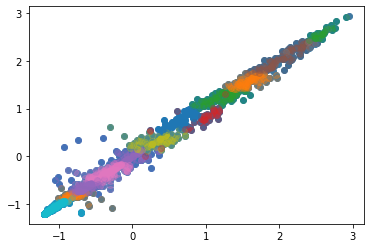

In [102]:
y = kmeans.labels_
plt.scatter(X2[:,0],X2[:,1])


for i in range(0,16):
    plt.scatter(X2[np.where(y==i),0],X2[np.where(y==i),1],alpha=0.3)

In [103]:
pca = decomposition.PCA(n_components=2)

In [104]:
X_pca = pca.fit_transform(X2)
print(X_pca.shape)


(1600, 2)


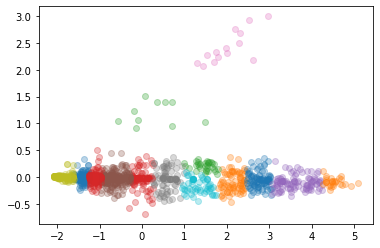

In [105]:
for i in range(0,16):
    plt.scatter(X_pca[np.where(y==i),0],X_pca[np.where(y==i),1],alpha=0.3)

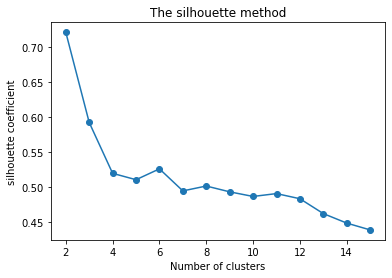

In [106]:
silhouette(X2)

In questo caso il numero di cluster in cui ho suddiviso non è coerente con il grafico di silhouette ottenuto.
Quindi il risultato ottenuto non è significativo

# Conclusioni

Rispetto all'analisi dei dati svolta, posso dire che la correlazione tra le varie azioni di trasporto è molto alta dal punto di vista della frequenza e vale la stessa cosa per la correlazione di trasporto e tocco del cubo di rubik.

Una scoperta interessante è data dal t-test in quanto risultano molto più simili tra loro le azioni di trasporto e tocco del cubo di rubik piutto che le varie azioni di trasporto, fatta eccezione per trasporto penna e trasporto cubo di rubik che hanno un p-value lievemente maggiore del livello di significatività.

Per quanto riguarda la classificazione con regressione logistica tra azioni di trasporto e tocco del cubo di rubik non si arriva a buoni risultati, ma questo potrebbe essere dovuto al fatto che risultino simili dal t-test. Mentre la regresssione logistica fatta per classificare le varie azioni di trasporto (bottiglia, tocco, cubo di rubik) da cui ci aspettavamo buoni risultati in quanto dal t-test queste azioni sono considerate distinte, da inspiegabilmente pessimi risultati, anche più deludenti rispetto alla precedente, infatti il regression score è minore del 50%.

Infine per quanto riguarda la clusterizzazione con kmeans riproponendo come cluster trasporto e tocco del cubo di rubik otteniamo che secondo l'indice di silhouette è corretto usare due cluster. Mentre la seconda clusterizzazione che divide in base alle persone, non da buoni risultati rispetto allo stesso indice.